# Two-box model

Twobox-modellen er en konseptuell modell for å illustrere betydningen av de ulike strålingspådrivene (ΔQ), tilbakekoblingseffektene (λ) and varmeopptaket i havet (γ). Modellen er forklart i vedlegget "Climate Sensitivity", og vi anbefaler dere å se i dette parallelt med den første modellkjøringen dere skal gjøre her.

I denne oppgaven skal dere ikke gjøre noen endringer i de ulike parameterne, dere skal nå bli kjent med modellen og ikke minst bli kjent med litt Python-kode.

## Jupyter notebook og Python

Klimamodellen er skrevet i programmeringsspråket Python, og er skrevet som en Jupyter notebook (som kan både åpnes lokalt på egen datamaskin, eller via online editorer som eksempelvis Cocalc. En notebook gjør det mulig å flette koden inn i tekst.

Når vi skal gjøre beregninger i klimamodellen, så trenger vi en del biblioteker, hvor vi finner ferdigprogrammerte matematiske funksjoner. Vi importerer `numpy` (https://numpy.org/) for matematiske funksjoner, `matplotlib.pyplot` (https://matplotlib.org/2.0.2/api/pyplot_api.html) for verktøy til å lage grafer og andre visualiseringer. Fra biblioteket `scipy` (https://docs.scipy.org/doc/scipy/reference/interpolate.html) vi bruke en funksjon for interpolasjon. 

### Kjøre kodebokser

Dere kjører koden under ved å trykke på Run-knappen når du er i kodeboksen. Det er viktig at du kjører alle kodebokser når de kommer. Noen kodebokser gir en output, som kommer like under kodeboksen, mens andre ikke viser noe. I kodeboksen under blir bibliotekene importert. Her er det også tatt med en `print`-kommando som skriver en output for å bekrefte at koden er kjørt. Senere vil vi ikke bruke disse.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
print("Da er bibliotekene du trenger importert, og er klare til bruk")

Da er bibliotekene du trenger importert, og er klare til bruk


## Hva representerer de ulike tilbakekoblingseffektene for klima?
Vi kan dele følsomheten som netto stråling ved toppen av atmosfæren ($R_{TOA}$) har på endringen i overflatetemperaturen i to:
* en direkte respons i netto stråling ved TOA fra en endring i overflatetemperaturen hvis alle andre klimaparametere er konstante
* en indirekte respons der endringer i temperaturen gir endringer i andre klimaparametere ($\chi_i$) som igjen gir en temperaturendring (tilbakekoblingseffekter - positive og negative)

Hvis vi ser vekk fra at klimaparameterne påvirker hverandre, får vi:

$$\dfrac{\delta R_{TOA}}{\delta T_S}=\left[\dfrac{\delta R_{TOA}}{\delta T_s}|_{\chi_i=0}\right]+ \sum_{i=1}^{N} \dfrac{\delta R_{TOA}}{\delta \chi_i}\dfrac{\delta \chi_i}{\delta T_s}  $$

Dette uttrykket gir oss at den totale endringen i overflatetemperaturen er:
* direkte endring i temperatur grunnet endringer i strålingspådriv (første ledd på høyre side)
* tilbakekoblingseffekter som påvirker $\Delta T_S$ (andre ledd på høyre siden). 

Dette gir oss en definisjon av de ulike feedback-faktorene $\lambda \equiv \tfrac{\delta R_{TOA}}{\delta T_S}$ som videre gir 

$$\lambda = -\left[\tfrac{\delta R_{TOA}}{\delta T_s}|_{\chi_i=0}\right]+ \sum_{i=1}^{N} \dfrac{\delta R_{TOA}}{\delta \chi_i}\dfrac{\delta \chi_i}{\delta T_s}$$

Tilbakekoblingseffektene avhenger egentlig av en rekke parametere. Den direkte endringen i strålingsbalansen via temperaturendring og Stefan-Boltzmanns lov (https://snl.no/Stefan-Boltzmanns_lov) er egentlig ikke en tilbakekoblingseffekt, men vi behandler det som en parameter på samme måte som de andre tilbakekoblingseffektene, og kaller den for $\lambda_{Planck}$. Tilsvarende får vi parametere for det som skyldes vanndamp, skyer, albedo osv. 

$$\lambda = \lambda_{Planck}+\lambda_{water}+\lambda_{clouds}+\lambda_{albedo}+...$$


## Tilbakekoblingseffekter $\lambda$
I henhold til CMIP5 (https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip5) så vil verdiene for de ulike tilbakekoblingsparameterne ha verdier innen følgende intervall.
Alle verdiene er CMIP5-verdier gitt i $\tfrac{W}{m^2 K}$

| Tilbakekoblingseffekt                              |      Verdier |
|:---------------------------------------------------|:-------------|
| Planck (direkte endring grunnet endret temperatur) | [-3.3, -3.1] |
| Lapse rate (vertikal temperaturgradient)           | [-1.2, -0.5] |
| Vanndamp                                           |   [1.5, 2.2] |
| Skyer                                              |   [0.1, 1.2] |
| Albedo (overflaten)                                |   [0.1, 0.4] |
| Andre faktorer                                     |              |

I denne testkjøringen av modellen velger vi følgende verdier:

In [2]:
lambda_planck=-3.2    
lambda_lapse=-0.8     
lambda_water=1.8      
lambda_cloud=0.70     
lambda_albedo=0.30    
lambda_other=0.0

#### Har du husket å kjøre kodeboksen?
Nå er det viktig at du kjører kodeboksen over, slik at verdiene også lagres i minnet på Jupyter.

In [3]:
lambda_sum=sum([lambda_planck,
    lambda_lapse,
    lambda_water,
    lambda_cloud,
    lambda_albedo,
    lambda_other]) # vi definerer den totale tilbakekoblingen som summen av de ulike parameterne

# Historiske klimadata

Vi starter med å se på historiske data, funnet i FNs femte klimarapport ( https://www.ipcc.ch/site/assets/uploads/2017/09/WG1AR5_AnnexII_FINAL.pdf side 1404). Dataene er samlet i filen `./FORCING_DATA/IPCC_AR5_historical_Forcings.txt` , der vi finner verdier for effektive strålingspådriv fra ulike faktorer. Filen inneholder årlige verdier fra 1750 til 2011 for strålingspådriv som skyldes CO<sub>2</sub>, andre drivhusgasser, troposfærisk og stratosfærisk ozon, aerosoler, arealbruksendringer (LUC), vanndamp i stratosfæren, svart karbon på snø, kondensstriper, solflekkaktivitet og vulkansk aktivitet. I vår forenklete klimamodell ser vi på drivhusgasser samlet

I kodeboksen under skal vi lese inn verdiene fra filen, sånn at vi kan plotte dem med Python.

In [4]:
print('TwoBox_read_IPCC_AR5_historical_forcing: reading IPCC AR5 forcing data 1750-2011')
year,co2_data,ghg_other_data,o3_tropos_data,o3_stratos_data,total_aero_data,landuse_data,h2o_stratos_data,bc_snow_data,contrails,solar_data,volc_data=(np.array(()),)*12
with open('./FORCING_DATA/IPCC_AR5_historical_Forcings.txt', 'r') as f:
    for i,line in enumerate(f):
        if i > 0:       # skip header (first line)
            values=line.strip('\n').split()
            if not values:
                continue   # skip last row in file if it is empty
            year=np.append(year, int(values[0]))
            co2_data=np.append(co2_data, float(values[1]))
            ghg_other_data=np.append(ghg_other_data, float(values[2]))
            o3_tropos_data=np.append(o3_tropos_data, float(values[3]))
            o3_stratos_data=np.append(o3_stratos_data, float(values[4]))
            total_aero_data=np.append(total_aero_data, float(values[5]))
            landuse_data=np.append(landuse_data, float(values[6]))
            h2o_stratos_data=np.append(h2o_stratos_data, float(values[7]))
            bc_snow_data=np.append(bc_snow_data, float(values[8]))
            contrails=np.append(contrails, float(values[9]))
            solar_data=np.append(solar_data, float(values[10]))
            volc_data=np.append(volc_data, float(values[11]))
print('TwoBox_read_IPCC_AR5_historical_forcing: Finished')

TwoBox_read_IPCC_AR5_historical_forcing: reading IPCC AR5 forcing data 1750-2011
TwoBox_read_IPCC_AR5_historical_forcing: Finished


### Fastsatte konstanter i modellen

Noen av konstantene under er satt for å forenkle modellen. Noen er tilnærmete verdier basert på empiri, mens andre er beregnet ut fra andre konstanter. Disse skal dere ikke endre. 

Verdiene det her er snakk om er gjennomsnittlig tykkelse av det øverste laget i havet, samt gjennomsnittsdypet av verdenshavene. I tillegg er det noen konstanter som vannets tetthet, spesifikk varmekapasitet til vann, og hvor stor andel av jorden som er dekket av hav. Til slutt beregnes den effektive varmekapasiteten for vekselvirkningen mellom atmosfære og hav.

In [5]:
# --------------
# ocean depths [m]
# --------------
# mixed layer thickness [m]
H_MIX= 100
# rest of the ocean [m]     
H_DEEP=3700-H_MIX    

# --------------
# Some constants
# -------------
#density of water (kg m-3)
RHO = 1000
#specific heat capacity of water (J kg-1 K-1)
CPO = 4200       
# fraction of earth that is ocean
f_o=0.7

# --------------
# Some derived constants
# -------------
# effective heat capacity of the atmosphere-ocean system [J m-2 K-1]
CEFF_M=f_o*H_MIX*CPO*RHO
CEFF_D=f_o*H_DEEP*CPO*RHO

### Variabler

Nå har vi fått definert en del variabler som arrays, som vi kan jobbe videre med. I denne første modellen ønsker vi bare å se på drivhusgassene, så det er bare de vi jobber videre med. 

Siden modellen skal gjøres mer generell, så vil vi også endre noen av variabelnavnene, sånn at vi kan lage egne funksjoner senere. 

In [6]:
total_year=year
total_forcing=co2_data+ghg_other_data
# Vi ønsker også å lage en 'dictionary' med informasjon til plotting senere
# Først lager vi en array med bare verdien 0 for alle årstallene
radiative_forcing=np.zeros(len(total_year))
forcings_dict={}

radiative_forcing=radiative_forcing+co2_data
forcings_dict['CO2']=co2_data
radiative_forcing=radiative_forcing+ghg_other_data
forcings_dict['OTHER GREENHOUSE GASES']=ghg_other_data

I denne første enkle versjonen av klimamodellen ser vi ikke på varmeopptak i havet.

### Tidsstep
Når man kjører numeriske modeller, så vil det kunne oppstå feil i resultatene hvis man har for lange tidsstep i modellkjøringene. Selv om de dataene vi har som input til modellen er årlige data, så må vi kjøre modellen med langt kortere tidsskritt for å unngå for store feil i beregningene, og vi må ha sekunder som tidsskritt i stedet. Husk at $\dfrac{d}{dt}$ er gitt i sekunder.

Vi bruker også en lineær interpolering mellom de ulike datapunktene. 

In [7]:
model_year=total_year
# -------------
# Timestep etc.
# --------------

# timestep in seconds
Dt=365*24*60*60

# interpolate forcing to chosen timestep
model_year_interp=np.arange(model_year[0], model_year[-1]+1, 1)
radiative_forcing_interp_fun=interpolate.interp1d(model_year, radiative_forcing, 'linear')
radiative_forcing_interp=radiative_forcing_interp_fun(model_year_interp)

# Number of timesteps to run model for
Nt=len(model_year_interp)


In [8]:
Ts_all=np.zeros(Nt)
Ts_init=0
Ts=np.array(()) # initialize arrays where individual time series will be stored
for t in range(Nt):
    # --------------
    # Temperature tendencies [K/s]
    #     dTs/dt, dTs_dt
    # --------------
    
    if t==0:
        dTs_dt=(radiative_forcing_interp[t]+(lambda_sum*Ts_init))/CEFF_M
    else:
        dTs_dt=(radiative_forcing_interp[t]+(lambda_sum*Ts[t-1]))/CEFF_M
    
    # ----------------------------------------------------------------------
    # Step temperature forward in time (by "Euler forward"
    # or "forward-in-time" method)
    #----------------------------------------------------------------------
    if t==0:
        Ts=np.append(Ts, Ts_init+dTs_dt*Dt)
    else:
        Ts=np.append(Ts, Ts[t-1]+dTs_dt*Dt)

Ts_all = Ts


In [9]:
#----------------------------------------------------------------------
# Plot data
#---------------------------------------------------------------------

# ----------------
# Select reference period
# Temp anomalies are in mean 0 over the reference period
# ------------------

# reference period for making anomalies 
ref_syr=1961
ref_eyr=1990

# make model  anomalies  relative to reference period
indx=np.logical_and(model_year>ref_syr, model_year<=ref_eyr)
Ts_anom=np.zeros(Nt)
Ts_anom=Ts_all-np.mean(Ts_all[indx])

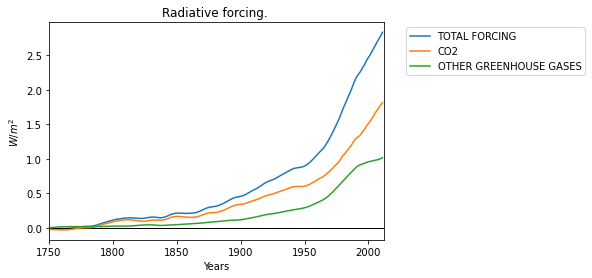

In [12]:
# -------------
# plot timeseries of forcings
# -------------------

# years to plot
plot_syr=total_year[0]
plot_eyr=total_year[-1]

# Data to plot        
plot_x=np.arange(plot_syr, plot_eyr+1)
plot_data=np.nan*np.ones((int(plot_eyr+1-plot_syr)))

# select times to plot
plot_data[np.isin(plot_x, model_year)]=radiative_forcing[np.isin(model_year, plot_x)]

# axis limits
xaxes_limits=((plot_syr, plot_eyr+1))
yaxes_limits=[]
# legend
legend_text='TOTAL FORCING'

y_label='$W/m^2$'
x_label='Years'
figure_text='Radiative forcing. '

ps=[]
Figure1=plt.figure(1)
x=plot_x
y=plot_data

p, =plt.plot(x,y, label=legend_text)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(figure_text)

plt.xlim(xaxes_limits)
if yaxes_limits:
    plt.ylim(yaxes_limits)

plt.axhline(y=0, linewidth=1, color="black")
ps.append(p)
for forcing in forcings_dict.keys():
    plot_data=forcings_dict[forcing]
    y=plot_data
    legend_text=forcing
    p2,=plt.plot(x,y, label=legend_text)
    ps.append(p2)
plt.legend(handles=ps, bbox_to_anchor=(1.05, 1), loc='upper left')


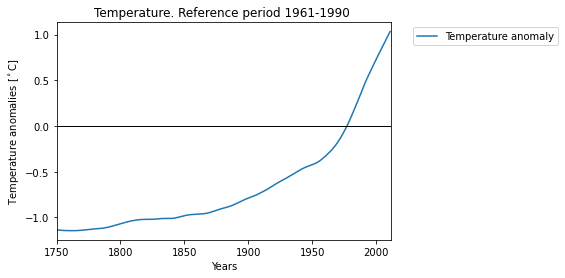

In [13]:
ps=[]
Figure2=plt.figure(2)
# Data to plot        
plot_x=np.arange(plot_syr, plot_eyr+1)
plot_data=Ts_anom

# select times to plot
plot_data[np.isin(plot_x, model_year)]=Ts_anom[np.isin(model_year, plot_x)]
        
yaxes_limits=((np.min(plot_data)-.1, np.max(plot_data)+.1))
y_label='Temperature anomalies [$^\circ$C]'
figure_text=f'Temperature. Reference period {ref_syr}-{ref_eyr} ' 
legend_text='Temperature anomaly'
x=plot_x
y=plot_data
p, =plt.plot(x,y, label=legend_text)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(figure_text)

plt.xlim(xaxes_limits)
if yaxes_limits:
    plt.ylim(yaxes_limits)

plt.axhline(y=0, linewidth=1, color="black")
ps.append(p)
plt.legend(handles=ps,  bbox_to_anchor=(1.05, 1), loc='upper left')

